In [1]:
%pylab inline

import theano
import theano.tensor.signal.downsample

from fuel.transformers import ScaleAndShift, Cast
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme, SequentialScheme

from blocks import *

import time

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 780 (CNMeM is enabled)


In [71]:
### Generic config

Config = {'batchsize-train' : 40, # 100
          'batchsize-validation' : 400,
          'batchsize-test' : 400,
          'theano-debug' : False,
         }

theano.config.floatX = 'float32'
theano.config.compute_test_value = 'off'
if Config['theano-debug']:
    print "Set Theano to debug mode."
    theano.config.optimizer = 'fast_compile'
    theano.config.exception_verbosity = 'high'
else:
    theano.config.optimizer = 'fast_run'
    theano.config.exception_verbosity = 'low'


In [72]:
from fuel.datasets.cifar10 import CIFAR10

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'})
)

Data_Train      = CIFAR10(("train",), subset=slice(None ,40000))
Data_Validation = CIFAR10(("train",), subset=slice(40000, None))
Data_Test       = CIFAR10(("test" ,)                           )

Stream_Train     = DataStream.default_stream(
                      Data_Train,
                      iteration_scheme=ShuffledScheme(Data_Train.num_examples       , Config['batchsize-train'])
                   )
Stream_Validation = DataStream.default_stream(
                      Data_Validation,
                      iteration_scheme=SequentialScheme(Data_Validation.num_examples, Config['batchsize-validation'])
                   )
Stream_Test       = DataStream.default_stream(
                      Data_Test,
                      iteration_scheme=SequentialScheme(Data_Test.num_examples      , Config['batchsize-test'])
                   )

print "Loaded input data."
print "Subset sizes: Train %d, Validation %d, Test %d" % (Data_Train.num_examples, Data_Validation.num_examples, Data_Test.num_examples)

def GetNextBatch(stream):
    return next(stream.get_epoch_iterator())

print "Stream data shapes:"
x,y = GetNextBatch(Stream_Train)
print "Stream_Train: image batch of shape %s [%s], and label batch of shape %s [%s]" % (x.shape, x.dtype, y.shape, y.dtype)
x,y = GetNextBatch(Stream_Test)
print "Stream_Test: image batch of shape %s [%s], and label batch of shape %s [%s]" % (x.shape, x.dtype, y.shape, y.dtype)

Loaded input data.
Subset sizes: Train 40000, Validation 10000, Test 10000
Stream data shapes:
Stream_Train: image batch of shape (40, 3, 32, 32) [float32], and label batch of shape (40, 1) [uint8]
Stream_Test: image batch of shape (400, 3, 32, 32) [float32], and label batch of shape (400, 1) [uint8]


In [73]:
class Layer_Conv2D_NoBias():
    def __init__(self, in_sets, out_sets, kern_size = 5):
        self.in_sets, self.out_sets, self.kern_size = in_sets, out_sets, kern_size
    def build(self, input, n):
        Kern = theano.shared(np.zeros((self.out_sets,self.in_sets,self.kern_size,self.kern_size), dtype='float32'), name=("CW%d" % n))
        Kern.tag.initializer = IsotropicGaussian(0.001)
        out = theano.tensor.nnet.conv2d(input, Kern, filter_shape=(self.kern_size,self.kern_size))
        return out, [Kern], [], ('conv2d',True,False)

class Layer_Pool2D():
    def __init__(self, pool_size):
        self.pool_size = pool_size
    def build(self, input, n):
        out = theano.tensor.signal.downsample.max_pool_2d(input, (self.pool_size,self.pool_size), ignore_border=True)
        return out, [], [], ('pool2d',True,False)
    
class Layer_Sigmoid():
    def __init__(self):
        pass
    def build(self, input, n):
        sigm = theano.tensor.nnet.sigmoid(input)
        return sigm, [], [], ('sigm',True,True)

class Layer_ReLU():
    def __init__(self):
        pass
    def build(self, input, n):
        relu = theano.tensor.maximum(0.0, input)
        return relu, [], [], ('relu',True,True)
    
class Layer_BN():
    def __init__(self, size, alpha=1.0):
        self.size, self.alpha = size, alpha
    def build(self, input, n):
        Gamma = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NG%d" % n))
        Beta  = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NB%d" % n))
        Gamma.tag.initializer = Constant(1.0)
        Beta.tag.initializer = Constant(0.0)
    
        stored_means = theano.shared(np.zeros((self.size,), dtype='float32'), name=("S_M%d" % n))
        stored_stds  = theano.shared(np.zeros((self.size,), dtype='float32'), name=("S_S%d" % n))
        stored_means.tag.initializer = Constant(0.0)
        stored_stds.tag.initializer = Constant(1.0)
    
        means = theano.tensor.mean(input, 0, keepdims=True)
        stds = theano.tensor.std(input, 0, keepdims=True)
        
        means = self.alpha * means + (1.0 - self.alpha) * stored_means.dimshuffle('x',0)
        stds = self.alpha * stds + (1.0 - self.alpha) * stored_stds.dimshuffle('x',0)
        
        normalized = theano.tensor.nnet.bn.batch_normalization(
            input,
            Gamma.dimshuffle('x',0),
            Beta.dimshuffle('x',0),
            means,
            stds,
            'high_mem'
        )
        
        return normalized, [Beta, Gamma], [
            (stored_means, means.dimshuffle(1)),
            (stored_stds,stds.dimshuffle(1))
        ], ('bn',False,False)
    
class Layer_BN_2D():
    def __init__(self, size, alpha=1.0):
        self.size, self.alpha = size, alpha
    def build(self, input, n):
        Gamma = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NG%d" % n))
        Beta  = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NB%d" % n))
        Gamma.tag.initializer = Constant(1.0)
        Beta.tag.initializer = Constant(0.0)
    
        stored_means = theano.shared(np.zeros((self.size,), dtype='float32'), name=("S_M%d" % n))
        stored_stds  = theano.shared(np.zeros((self.size,), dtype='float32'), name=("S_S%d" % n))
        stored_means.tag.initializer = Constant(0.0)
        stored_stds.tag.initializer = Constant(1.0)
    
        means = theano.tensor.mean(input, (0,2,3), keepdims=True)
        stds = theano.tensor.std(input, (0,2,3), keepdims=True)
        
        means = self.alpha * means + (1.0 - self.alpha) * stored_means.dimshuffle('x',0,'x','x')
        stds = self.alpha * stds + (1.0 - self.alpha) * stored_stds.dimshuffle('x',0,'x','x')
        
        normalized = theano.tensor.nnet.bn.batch_normalization(
            input,
            Gamma.dimshuffle('x',0,'x','x'),
            Beta.dimshuffle('x',0,'x','x'),
            means,
            stds,
            'high_mem'
        )
        
        return normalized, [Beta, Gamma, stored_means, stored_stds], [
            (stored_means, means.dimshuffle(1)),
            (stored_stds,stds.dimshuffle(1))
        ], ('bn2d',False,False)


class Layer_FullyConnected():
    def __init__(self, in_sets, out_sets):
        self.in_sets, self.out_sets = in_sets, out_sets
    def build(self, input, n):
        W    = theano.shared(np.zeros((self.in_sets, self.out_sets), dtype='float32'), name=("FW%d" % n))
        Bias = theano.shared(np.zeros((self.out_sets,), dtype='float32'), name=("FB%d" % n))
        W.tag.initializer = IsotropicGaussian(0.05)
        Bias.tag.initializer = Constant(0.0)
        out = theano.tensor.dot(input, W) + Bias.dimshuffle('x',0)
        return out, [W, Bias], [], ('fc',False,False)

class Layer_FullyConnected_NoBias():
    def __init__(self, in_sets, out_sets):
        self.in_sets, self.out_sets = in_sets, out_sets
    def build(self, input, n):
        W    = theano.shared(np.zeros((self.in_sets, self.out_sets), dtype='float32'), name=("FW%d" % n))
        W.tag.initializer = IsotropicGaussian(0.05)
        out = theano.tensor.dot(input, W)
        return out, [W], [], ('fcnb',False,False)

class Layer_2Dto1D():
    def __init__(self):
        pass
    def build(self, input, n):
        return input.flatten(2), [], [], ('2to1',False,False)
class Layer_DebugPeek():
    def __init__(self):
        pass
    def build(self, input, n):
        return input, [], [], ('debug',True,True)

In [74]:
class NetworkBuilder():
    def __init__(self, layerlist):
        self.layers = layerlist
    def build(self, input):
        self.middle_layers = []
        self.middle_tags = []
        params, updates = [], []
        current = input
        i = 0
        for layer in self.layers:
            current, p, u, t = layer.build(current, i)
            params += p
            updates += u
            i += 1
            self.middle_layers += [current]
            self.middle_tags += [t]
        return current, params, updates

In [86]:
Input_X = theano.tensor.tensor4('X')
Input_Y = theano.tensor.matrix('Y', dtype='uint8')
"""
network = NetworkBuilder([ # R1
        Layer_Conv2D_NoBias(3, 64, kern_size=3),
        Layer_Pool2D(pool_size=3),
        Layer_BN_2D(64),
        Layer_ReLU(),
        Layer_Conv2D_NoBias(64, 128, kern_size=3),
        Layer_Pool2D(pool_size=2),
        Layer_BN_2D(128),
        Layer_ReLU(),
        Layer_2Dto1D(),
        Layer_FullyConnected_NoBias(128*4*4,1024),
        Layer_BN(1024),
        Layer_ReLU(),
        Layer_FullyConnected_NoBias(1024,512),
        Layer_BN(512),
        Layer_Sigmoid(),
        Layer_FullyConnected(512,10)
    ])
"""
network = NetworkBuilder([ # R2
        Layer_Conv2D_NoBias(3, 64, kern_size=3),
        Layer_Pool2D(pool_size=3),
        #Layer_BN_2D(64),
        Layer_ReLU(),
        Layer_Conv2D_NoBias(64, 128, kern_size=3),
        Layer_Pool2D(pool_size=2),
        #Layer_BN_2D(128),
        Layer_ReLU(),
        Layer_2Dto1D(),
        Layer_FullyConnected_NoBias(128*4*4,1024),
        #Layer_BN(1024),
        Layer_ReLU(),
        Layer_FullyConnected_NoBias(1024,512),
        #Layer_BN(512),
        Layer_Sigmoid(),
        Layer_FullyConnected(512,10)
    ])


out, ParamList, UpdatesFromLayers = network.build(Input_X)

Output_Probabilities = theano.tensor.nnet.softmax(out)

Output_Predictions   = theano.tensor.argmax(Output_Probabilities, axis=1)

Output_ErrRate = theano.tensor.neq(Output_Predictions,Input_Y.ravel()).mean()
Output_NLL     = - theano.tensor.log(Output_Probabilities[theano.tensor.arange(Input_Y.shape[0]), Input_Y.ravel()]).mean()

# wdecay_alpha = 3e-3
# wdecay_alpha = 1e-2
# wdecay_alpha = 4e-2
# wdecay_alpha = 8e-2 # R1
# wdecay_alpha = 3e-3 # R2
wdecay_alpha = 1.5e-3 # R2'

Output_WeightDecay = 0.0
for p in ParamList:
    if p.name[1] == 'W':
        Output_WeightDecay = Output_WeightDecay + wdecay_alpha * (p**2).sum()

Output_Cost = Output_NLL + Output_WeightDecay


In [87]:
# The updates will update our shared values
updates = []

Input_LRate    = theano.tensor.scalar('lrate',dtype='float32')
Input_Momentum = theano.tensor.scalar('momentum',dtype='float32')

# Theano will compute the gradients for us
Model_Gradients = theano.grad(Output_Cost, ParamList)

#initialize storage for momentum
Model_Velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in ParamList]

for p,g,v in zip(ParamList, Model_Gradients, Model_Velocities):
    if p.name[1] == '_':
        print "non trainable: %s" % p.name
        continue
    v_new = Input_Momentum * v - Input_LRate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]
    
updates += UpdatesFromLayers
    
Debug_Vars = []

In [88]:
#compile theano functions

#each call to train step will make one SGD step
Function_TrainStep = theano.function(
    [Input_X,Input_Y,Input_LRate,Input_Momentum],
    [Output_Cost, Output_ErrRate, Output_NLL, Output_WeightDecay],
    updates=updates,
    allow_input_downcast=True
)
Function_TrainStep_Debug = theano.function(
    [Input_X,Input_Y,Input_LRate,Input_Momentum],
    [Output_Cost, Output_ErrRate, Output_NLL, Output_WeightDecay] + Debug_Vars,
    updates=updates,
    allow_input_downcast=True
)
#each call to predict will return predictions on a batch of data
Function_Predict = theano.function(
    [Input_X],
    Output_Predictions
)

In [89]:
rng = numpy.random.RandomState(42)

def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (Function_Predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples

def init_parameters():
    global rng
    for p in ParamList:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in ParamList]

def load_parameters(snapshot):
    for p, s in zip(ParamList, snapshot):
        p.set_value(s, borrow=False)

In [98]:
i=0
e=0

init_parameters()
for v in Model_Velocities:
    v.set_value(np.zeros_like(v.get_value()))

Training_Best_ErrRate = np.inf
Training_Best_Params = snapshot_parameters()
Training_Best_Epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

Training_StartTime = time.time()

print Debug_Vars

while e<number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    epoch_start_i = i
    
    epoch_starttime = time.time()
    for X_batch, Y_batch in Stream_Train.get_epoch_iterator(): 
        i += 1
        
        K = 2000 # R2
        # K = 600 # R1
        # lrate = 4e-3 * K / np.maximum(K, i)
        lrate = 1e-2 * K / np.maximum(K, i)
        # lrate = 3e-3 * K / np.maximum(K, i) # R1
        momentum = 0.9
        
        # momentum = 1.0 - np.maximum(np.minimum(200.0/(i+1), 0.4), 0.01)
        if i % 1000 == 1000000:
            t = Function_TrainStep_Debug(X_batch, Y_batch, lrate, momentum)
            L, err_rate, nll, wdec = t[0:4]
            debugvars = t[4:]
            for a in debugvars:
                dir(a)
                array = np.array(a)
                print array
        else:
            L, err_rate, nll, wdec = Function_TrainStep(X_batch, Y_batch, lrate, momentum)
        
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        if i % 1000 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)
        
    epoch_endtime = time.time()
    print "Time per epoch: %ss" % (epoch_endtime - epoch_starttime)
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(Stream_Validation)
    if val_error_rate < Training_Best_ErrRate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        Training_Best_ErrRate = val_error_rate
        Training_Best_Params = snapshot_parameters()
        Training_Best_Epoch = e
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1]))

Training_EndTime = time.time()
print "TOTAL TIME: %ss" % int(Training_EndTime - Training_StartTime)

[]
At minibatch 1000, batch loss 7.193509, batch nll 1.707101, batch error rate 70.000000%
Time per epoch: 16.8957998753s
After epoch 1: valid_err_rate: 60.870000% currently going to do 3 epochs
After epoch 1: averaged train_err_rate: 74.110000% averaged train nll: 2.023752 averaged train loss: 9.487773
At minibatch 2000, batch loss 4.792259, batch nll 1.703574, batch error rate 60.000000%
Time per epoch: 16.6872138977s
After epoch 2: valid_err_rate: 50.850000% currently going to do 4 epochs
After epoch 2: averaged train_err_rate: 56.247500% averaged train nll: 1.527704 averaged train loss: 5.693350
At minibatch 3000, batch loss 3.677481, batch nll 1.697273, batch error rate 55.000000%
Time per epoch: 16.6909511089s
After epoch 3: valid_err_rate: 44.240000% currently going to do 5 epochs
After epoch 3: averaged train_err_rate: 48.060000% averaged train nll: 1.325669 averaged train loss: 3.776132
At minibatch 4000, batch loss 2.503119, batch nll 1.026890, batch error rate 42.500000%
Tim

KeyboardInterrupt: 

In [99]:
## Finalizes training

print "Setting network parameters from after epoch %d" %(Training_Best_Epoch)
load_parameters(Training_Best_Params)

errrate = compute_error_rate(Stream_Test)
print "Test error rate is %f%%" %(errrate*100.0,)
print "Success rate is %f%%" %(100.0 - errrate*100.0,)

a_TNLL = np.array(train_nll)
a_TERR = np.array(train_erros)
a_VERR = np.array(validation_errors)

batches_per_epoch = 40000/Config['batchsize-train']

tpe = 13

a_TNLL_e, a_TERR_e, a_VERR_e = np.copy(a_TNLL), np.copy(a_TERR), np.copy(a_VERR)
a_TNLL_e[:,0] /= batches_per_epoch
a_TERR_e[:,0] /= batches_per_epoch
a_VERR_e[:,0] /= batches_per_epoch
a_TNLL_t, a_TERR_t, a_VERR_t = np.copy(a_TNLL_e), np.copy(a_TERR_e), np.copy(a_VERR_e)
a_TNLL_t[:,0] *= tpe
a_TERR_t[:,0] *= tpe
a_VERR_t[:,0] *= tpe

Setting network parameters from after epoch 68
Test error rate is 26.710000%
Success rate is 73.290000%


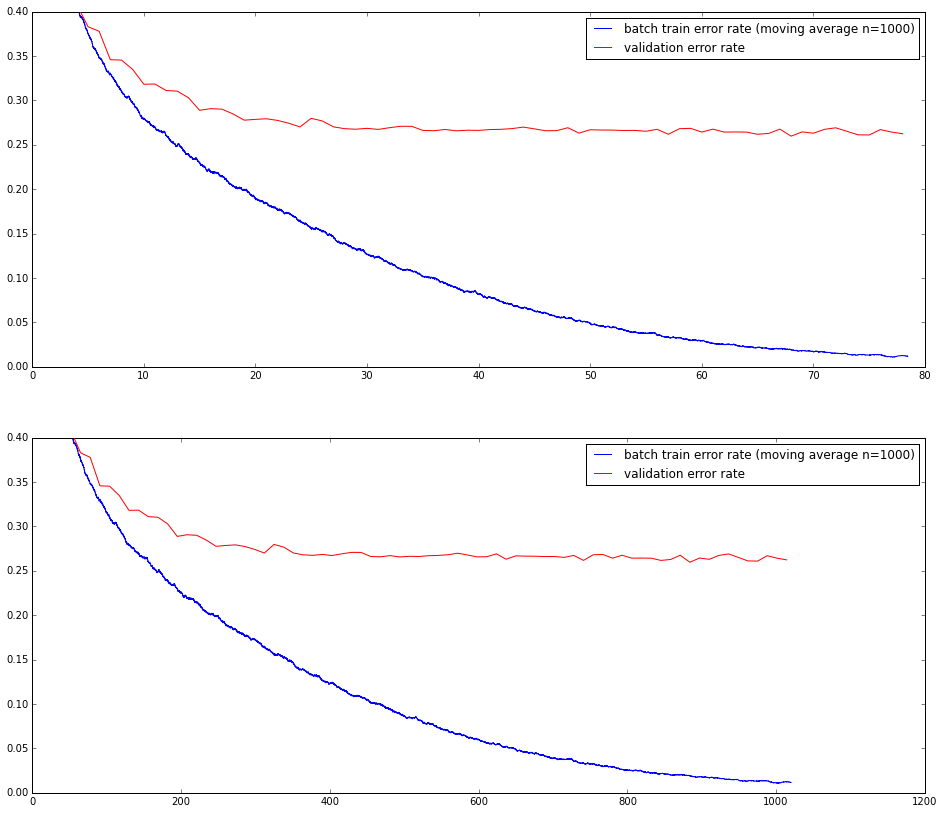

In [100]:
def moving_average(a, n=3, axis=0) :
    ret = np.cumsum(a, dtype=float, axis=axis)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

a_TNLL_e_smooth = moving_average(a_TNLL_e, n=1000, axis=0)
a_TERR_e_smooth = moving_average(a_TERR_e, n=1000, axis=0)
a_VERR_e_smooth = a_VERR_e
a_TNLL_t_smooth = moving_average(a_TNLL_t, n=1000, axis=0)
a_TERR_t_smooth = moving_average(a_TERR_t, n=1000, axis=0)
a_VERR_t_smooth = a_VERR_t

figure(figsize=(16,14))
#subplot(2,1,1)
#semilogy(a_TNLL_smooth[:,0], a_TNLL_smooth[:,1], label='batch train nll')
#legend()

subplot(2,1,1)
plot(a_TERR_e_smooth[:,0], a_TERR_e_smooth[:,1], label='batch train error rate (moving average n=1000)', zorder=0)
plot(a_VERR_e_smooth[:,0], a_VERR_e_smooth[:,1], label='validation error rate', color='r', zorder=10)
ylim(0,0.4)
legend()

subplot(2,1,2)
plot(a_TERR_t_smooth[:,0], a_TERR_t_smooth[:,1], label='batch train error rate (moving average n=1000)', zorder=0)
plot(a_VERR_t_smooth[:,0], a_VERR_t_smooth[:,1], label='validation error rate', color='r', zorder=10)
ylim(0,0.4)
legend()

In [14]:
### This cell stores parameters from a run!

### !!!!!!!!!!!!!!!!!!!!!

#train_nll_b = train_nll_a
#train_erros_b = train_erros_a
#validation_errors_b = validation_errors_a

b_TNLL = np.copy(a_TNLL)
b_TERR = np.copy(a_TERR)
b_VERR = np.copy(a_VERR)
b_TNLL_e = np.copy(a_TNLL_e)
b_TERR_e = np.copy(a_TERR_e)
b_VERR_e = np.copy(a_VERR_e)
b_TNLL_t = np.copy(a_TNLL_t)
b_TERR_t = np.copy(a_TERR_t)
b_VERR_t = np.copy(a_VERR_t)

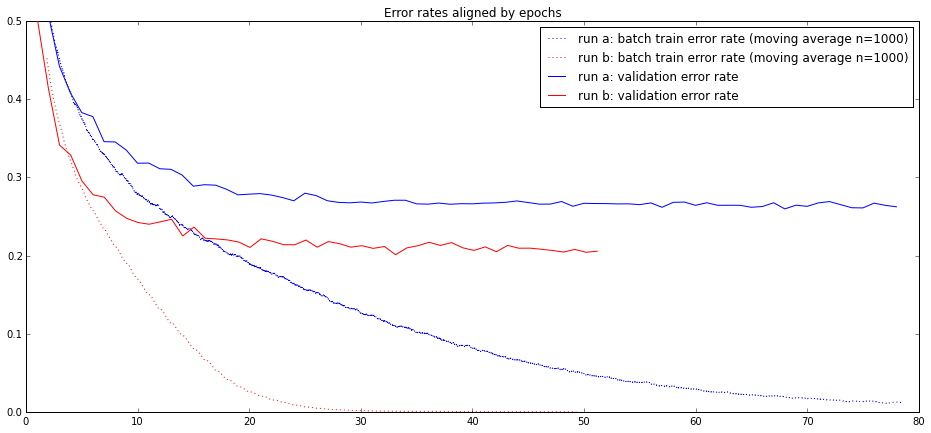

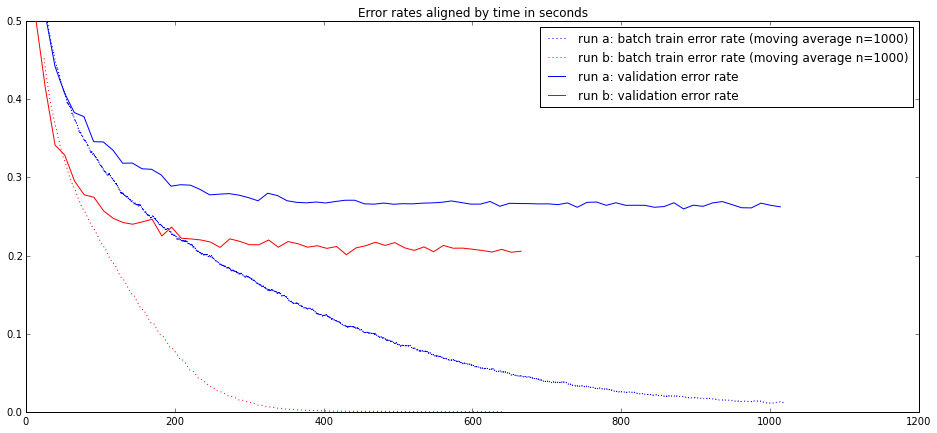

In [101]:
### Comparison chart

b_TNLL_e_smooth = moving_average(b_TNLL_e, n=1000, axis=0)
b_TERR_e_smooth = moving_average(b_TERR_e, n=1000, axis=0)
b_VERR_e_smooth = b_VERR_e
b_TNLL_t_smooth = moving_average(b_TNLL_t, n=1000, axis=0)
b_TERR_t_smooth = moving_average(b_TERR_t, n=1000, axis=0)
b_VERR_t_smooth = b_VERR_t

figure(figsize=(16,7))

title("Error rates aligned by epochs")
plot(a_TERR_e_smooth[:,0], a_TERR_e_smooth[:,1], 'b:', label='run a: batch train error rate (moving average n=1000)', zorder=0)
plot(b_TERR_e_smooth[:,0], b_TERR_e_smooth[:,1], 'r:', label='run b: batch train error rate (moving average n=1000)', zorder=0)
plot(a_VERR_e_smooth[:,0], a_VERR_e_smooth[:,1], 'b', label='run a: validation error rate', zorder=10)
plot(b_VERR_e_smooth[:,0], b_VERR_e_smooth[:,1], 'r', label='run b: validation error rate', zorder=10)
ylim(0,0.5)
legend()

figure(figsize=(16,7))

title("Error rates aligned by time in seconds")
plot(a_TERR_t_smooth[:,0], a_TERR_t_smooth[:,1], 'b:', label='run a: batch train error rate (moving average n=1000)', zorder=0)
plot(b_TERR_t_smooth[:,0], b_TERR_t_smooth[:,1], 'r:', label='run b: batch train error rate (moving average n=1000)', zorder=0)
plot(a_VERR_t_smooth[:,0], a_VERR_t_smooth[:,1], 'b', label='run a: validation error rate', zorder=10)
plot(b_VERR_t_smooth[:,0], b_VERR_t_smooth[:,1], 'r', label='run b: validation error rate', zorder=10)
ylim(0,0.5)
legend()

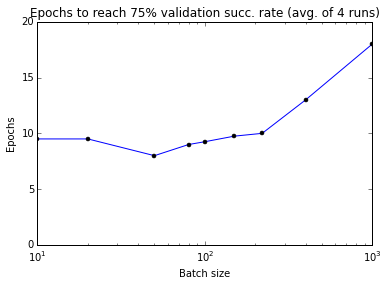

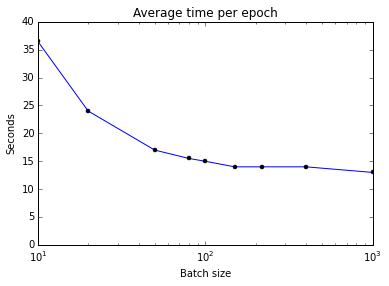

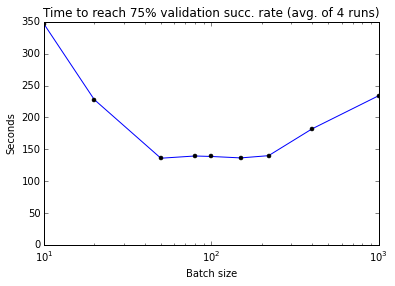

In [111]:
batch_sizes    =  np.array([  10,  20, 50,  80,  100,  150, 220, 400, 1000])
epochs_to_25   =  np.array([ 9.5, 9.5,  8,   9, 9.25, 9.75,  10,  13,   18])
time_per_epoch =  np.array([36.5,  24, 17,15.5,   15,   14,  14,  14,   13])
time_to_25 = epochs_to_25 * time_per_epoch

figure(figsize=(6,4))
plot(batch_sizes, epochs_to_25, marker='o', markersize=4, markerfacecolor='black')
xscale('log')
xlabel('Batch size')
ylabel('Epochs')
ylim((0,20))
title('Epochs to reach 75% validation succ. rate (avg. of 4 runs)')

figure(figsize=(6,4))
plot(batch_sizes, time_per_epoch, marker='o', markersize=4, markerfacecolor='black')
xscale('log')
xlabel('Batch size')
ylabel('Seconds')
ylim((0,40))
title('Average time per epoch')

figure(figsize=(6,4))
plot(batch_sizes, time_to_25, marker='o', markersize=4, markerfacecolor='black')
xscale('log')
xlabel('Batch size')
ylabel('Seconds')
ylim((0,350))
title('Time to reach 75% validation succ. rate (avg. of 4 runs)')

In [25]:
# Result reference file generation

predicted_labels = []
reference_labels = []
for X, Y in Stream_Test.get_epoch_iterator():
    predicted_labels += list(Function_Predict(X))
    reference_labels += list(Y.ravel())
report_string = ""
for p,r in zip(predicted_labels, reference_labels):
    report_string += str(p) + " " + str(r) + "\n"
with open("result.txt", "w") as text_file:
    text_file.write(report_string)

In [21]:
mid = network.middle_layers
print mid
middle_layers_computer = theano.function([Input_X], [Input_X] + mid)



[AbstractConv2d{border_mode='valid', subsample=(1, 1), filter_flip=True, imshp=None, kshp=(3, 3)}.0, DownsampleFactorMax{ds=(3, 3), ignore_border=True, st=(3, 3), padding=(0, 0), mode='max'}.0, Elemwise{add,no_inplace}.0, Elemwise{maximum,no_inplace}.0, AbstractConv2d{border_mode='valid', subsample=(1, 1), filter_flip=True, imshp=None, kshp=(3, 3)}.0, DownsampleFactorMax{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Elemwise{add,no_inplace}.0, Elemwise{maximum,no_inplace}.0, Reshape{2}.0, dot.0, Elemwise{add,no_inplace}.0, Elemwise{maximum,no_inplace}.0, dot.0, Elemwise{add,no_inplace}.0, sigmoid.0, Elemwise{add,no_inplace}.0]


(100, 3, 32, 32)


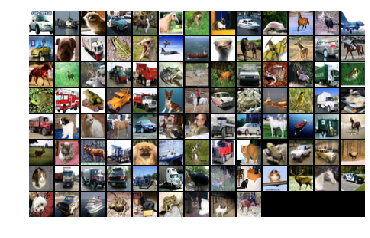

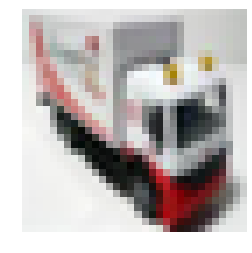

conv2d (64, 1, 30, 30)


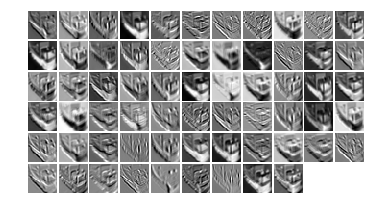

pool2d (64, 1, 10, 10)


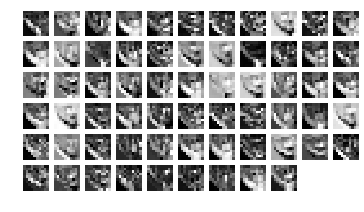

relu (64, 1, 10, 10)


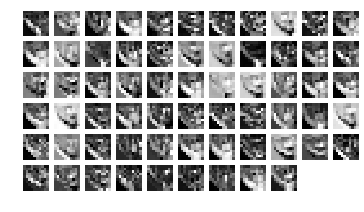

conv2d (64, 1, 10, 10)


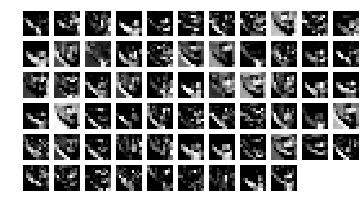

pool2d (128, 1, 8, 8)


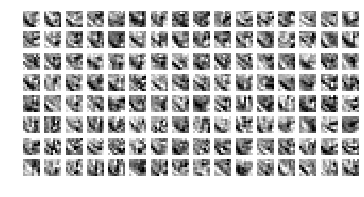

relu (128, 1, 4, 4)


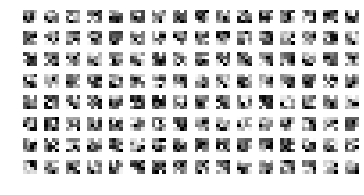

relu (1, 1, 2048, 1)


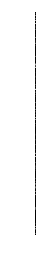

sigm (1, 1, 1024, 1)


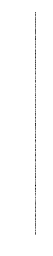

end


In [115]:

from common.plotting import plot_mat
test_batch, _ = GetNextBatch(Stream_Validation)
print test_batch.shape
plot_mat(test_batch)
show()

middle_layers = middle_layers_computer(test_batch)
i = 15

original = test_batch[i:i+1]
plot_mat(original)
show()

for layer, tag in zip(middle_layers[1:], network.middle_tags):
    if tag[1]:
        try:
            testimg = layer[i:i+1].transpose(1,0,2,3)
        except ValueError:
            testimg = layer[i:i+1][...,np.newaxis,np.newaxis]
        if testimg.shape[3] == 1:
            testimg = testimg.transpose(2,3,1,0)
        print tag[0], testimg.shape
        plot_mat(testimg, cmap='gray')
        show()
    
print 'end'